In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bartlett
import seaborn as sns
import scipy.stats as stats
# import shap
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [3]:
# 전처리
def resample_df(df):
    df = df.set_index(['create_dt'])
    df1 = df[['humidity','currenttemperature', 
          'airstate.tempstate.target', 'pm1', 'pm2', 'pm10','sensory_temp','DI']]
    df2 = df[['airstate.opmode', 'airstate.opmode2','day','hour','weekday','weekend','Clid']]
    df3 = df['energywatt']
    df4 = df['airstate.windstrength']
    df1 = df1.resample('H').mean()
    df2 = df2.resample('H').first()
    df3 = df3.resample('H').sum() / df3.resample('H').count()
    df4 = df4.resample('H').max()
    df3 = df3.replace(0, np.NaN)
    df1 = df1.interpolate(method='time')
    df2 = df2.interpolate(method='nearest')
    df3 = df3.interpolate(method='time',order=3)
    df4 = df4.interpolate(method='nearest')
    df2 = df2.astype('int')
    df4 = df4.astype('int')
    df = pd.concat([df1,df2,df3,df4],axis=1)
    return df

In [5]:
all_df = pd.read_csv('./data/all_data.csv')
dep_genes = pd.read_csv('DEP_genes.dat',sep='\t') # 클러스터 info

all_df = pd.merge(all_df,dep_genes,left_on='device_id_deidentification',right_on='GeneID',how='left')
all_df.dropna(subset=['Type'],inplace=True)

all_df['device_id_deidentification']=all_df['device_id_deidentification'].str[8:]
all_df['Clid'] = all_df['Clid'].astype(int)
all_df['create_dt'] = pd.to_datetime(all_df['create_dt']) # datetime으로 변경
all_df = all_df.drop(['GeneID', 'Type','airstate.miscfuncstate.uvnano','airstate.miscfuncstate.filtercleanauto'], axis=1) # 필요없는 칼럼 삭제

In [6]:
# create_dt 월 일 시간 주말 평일로 변환
all_df['month'] = all_df['create_dt'].dt.month
all_df['day'] = all_df['create_dt'].dt.day
all_df['hour'] = all_df['create_dt'].dt.hour
all_df['minute'] = all_df['create_dt'].dt.minute
all_df['weekday'] = all_df['create_dt'].dt.weekday
# all_df['weekday'] = all_df['create_dt'].apply(weekday)
all_df['weekend'] = all_df['create_dt'].apply(weekend)
all_df['date'] = all_df['create_dt'].dt.date

In [7]:
# 체감온도 변수 생성
all_df['sensory_temp']=13.12+0.6215*all_df['currenttemperature']-13.947*all_df['airstate.windstrength']**0.16+0.486*all_df['currenttemperature']*all_df['airstate.windstrength']**0.16
# 불쾌지수 변수 생성
all_df['DI'] = 0.81*all_df['currenttemperature'] + 0.01*all_df['humidity']*(0.99*all_df['currenttemperature']-14.3)+46.3

In [8]:
from tqdm import tqdm

device_info = all_df.groupby('device_id_deidentification')['energywatt'].sum().index

device_lst = []
for name in tqdm(device_info):
    df = all_df.loc[all_df['device_id_deidentification']==name]
    df = resample_df(df)
    df['currenttemperature'] = df['currenttemperature'].round(2)
    df['airstate.tempstate.target'] = df['airstate.tempstate.target'].round(0)

    column = ['airstate.opmode2','currenttemperature','energywatt','airstate.tempstate.target','airstate.windstrength','humidity']

    for c in column:
        df[f"prior_{c}"] = df[c].shift(1)
        
    df['diff_humidity'] = df['humidity']-df['prior_humidity']
    df['diff_temp'] = df['currenttemperature'] - df['currenttemperature'].shift(1)
    df['id'] = name
    device_lst.append(df)

100%|███████████████████████████████████████████████████████████████| 2233/2233 [09:05<00:00,  4.09it/s]


In [9]:
for df in tqdm(device_lst):
    df['inefficiency'] = 0
    condition1 = (df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(abs(df['diff_temp'])<0.5) # 냉방모드로 현재온도를 target temp보다 같거나 낮은 상태로 유지시킨 상태(A)
    condition2 = (df['currenttemperature']<=df['airstate.tempstate.target'])&(df['airstate.opmode']==1)&(abs(df['diff_temp'])<0.5)&(df['diff_humidity']>=1) # A상황에서 습도가 증가한 상태
    df.loc[condition1,'inefficiency']=1
    df.loc[condition2,'inefficiency']=2

100%|██████████████████████████████████████████████████████████████| 2233/2233 [00:05<00:00, 422.76it/s]


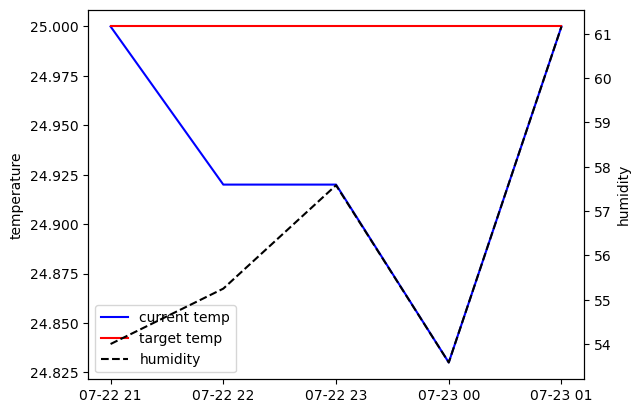

In [10]:
from datetime import timedelta
from matplotlib import dates

d = device_lst[1]
ineffi_index=d.loc[d['inefficiency']==2].index
idx=pd.date_range(start=ineffi_index[5]-timedelta(hours = 2),end=ineffi_index[5]+timedelta(hours = 2),freq='H')
dd = d.loc[idx,:]
fig,ax1 = plt.subplots()
l1 = ax1.plot(dd.index,dd['currenttemperature'],color='b',label = 'current temp')
l2 = ax1.plot(dd.index,dd['airstate.tempstate.target'],color='r',label = 'target temp')
ax1.set_ylabel('temperature')

ax2 = ax1.twinx()
l3 = ax2.plot(dd.index,dd['humidity'],'--',color='black',label='humidity')
ax2.set_ylabel('humidity')

ln = l1+l2+l3
labs = [l.get_label() for l in ln]
ax1.legend(ln, labs, loc=0)

ax1.xaxis.set_major_locator(dates.HourLocator(interval=1))
plt.show()

In [11]:
con_df = pd.DataFrame()
# pd.concat([device_lst[0],device_lst[1]],axis=0)
for i,dev in tqdm(enumerate(device_lst,start=1)):
#     dev['ID'] = i
    con_df=pd.concat([con_df,dev],axis=0)

2233it [00:29, 74.74it/s]


In [12]:
# 비효율성이 많이 나타나는 클러스터를 확인하기 위해 
inefficiency_clid = pd.DataFrame(con_df.groupby('Clid')['inefficiency'].value_counts())
inefficiency_clid.rename(columns = {'inefficiency':'rate'},inplace=True)
inefficiency_clid = inefficiency_clid.reset_index()
inefficiency_clid = inefficiency_clid.loc[inefficiency_clid['inefficiency'].isin([1,2])]
inefficiency_clid=inefficiency_clid.reset_index(drop=True)
sum_=inefficiency_clid.groupby('Clid')['rate'].sum().values
lst = np.arange(1,33,2)

for i in lst:
    inefficiency_clid.iloc[i,2] = inefficiency_clid.iloc[i,2]/(inefficiency_clid.iloc[i-1,2]+inefficiency_clid.iloc[i,2])

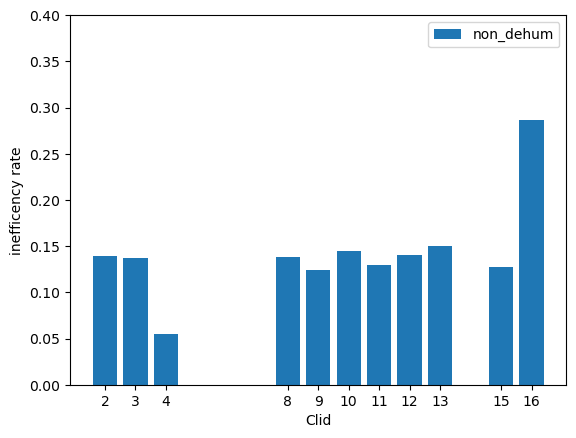

In [14]:
kk=inefficiency_clid.loc[inefficiency_clid['inefficiency']==2]
target_clid = [2,3,4,8,9,10,11,12,13,15,16]
k1 = kk.loc[kk['Clid'].isin(target_clid)]

plt.bar(k1['Clid'],k1['rate'],label='non_dehum')

# clid2 = [1,7,14]
# k2 = kk.loc[kk['Clid'].isin(clid2)]

# plt.bar(k2['Clid'],k2['rate'],label='active')
# clid.extend(clid2)

plt.xticks(target_clid)
plt.ylim(0,0.4)
plt.xlabel('Clid')
plt.ylabel('inefficency rate')
plt.legend()
plt.show()

In [15]:
target_df = con_df.loc[con_df['Clid'].isin(target_clid)]

In [18]:
target_df.to_csv('./data/target_df.csv') # 시뮬레이션 해야할 데이터

In [19]:
active_clid = [1,7,14]
active_df = con_df.loc[con_df['Clid'].isin(active_clid)] # 제습모드를 통해 회귀모델을 적합할 데이터
active_df.to_csv('./data/active_df(회귀모델용).csv')

In [52]:
target_df['inefficiency'].value_counts()

1    252251
0    190877
2     39272
Name: inefficiency, dtype: int64

In [20]:
con_df.to_csv('./data/target_temp_analysis.csv')